# Preparing simulation data for ISOKANN
Date: 08.10.2025

In this notebook we prepare the simulation data into the required data structure for ISOKKAN.
With the new version of the ABM, where farms' initial capital are initialized randomly. 

To estimate the chi functions ISOKANN requires two kinds of samples:
1. xs : starting points. It's 2-dimensional array of size = n_dim x n_samples. 
2. ys : propagated points. It is a 3-dimensional array of size = n_dim x n_koop x_samples.

Where n_dim = is the size of the state or feature state, n_samples is the total number of samples and n_koop is the number of Koopman-samples per starting point. Since we are working with time series, n_koop = 1. (For more information read:https://axsk.github.io/ISOKANN.jl/dev/introduction/ )


In [1]:
#import functions from src file
import os
import sys

# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.ABRam_BG_V01 import *

In [2]:
#Import necessary packages 
import pandas as pd
import numpy as np
import agentpy as ap
import matplotlib.pyplot as plt

In [3]:
#We set the parameter values for the farms
alpha, delta, rho = 0.33, 0.05, 0.99
#Parameter such that farms investment is bigger that its capital depreciation, i.e I > delta K
Omega = (delta + (1/(rho*alpha)))**(1/(1 - alpha))
#Parameter such that farms investment is positive
omega = ((1-delta)/(alpha*rho))**(1/(1-alpha))
#Periods 
periods = 50

In [4]:
# Configuration with 5% green in the system
perc = 0.30

#Number of farms in the system
Farms = 100
green_farms = int(perc*Farms)
brown_farms = Farms - green_farms

#Total Initial capital in the systes
Tot_K0 = 10
Tot_G0 = perc*Tot_K0
Tot_B0 = Tot_K0 - Tot_G0

#Farms initial capital (Initially, they just own one type of capital)
frm_B0 = Tot_B0/brown_farms
frm_G0 = Tot_G0/green_farms

#Initial technical progress
gamma0 = Omega*frm_G0 + 1
beta0 = gamma0/perc

In [5]:
#We declare the dictionary of parameters for the simulation 
parameters = {
    'agents':Farms,
    'steps': periods,
    'delta': delta,
    'alpha': alpha,
    'rho': rho,
    'green_perc': perc,
    'Tot_K0': Tot_K0,

    'interaction': True, #False
    'opinion_dynamics': True,
    'interaction_type': 'Voter', #MajorityRule
    'interacting_farms':3,#[0,3,0,3,3,0,1],
    'network_topology': 'FC',
    'number_of_friends': 5,
    'network_randomness': 0.5,
    'time_steps_in_1_year':4,
    'seed':42,
    'emissions':False,
    'draw_network':False #For visualization draw initial and final network
}

# # #We run the model 
# model = Economy(parameters)
# r_constant = model.run()

#Sample generation
# sample = ap.Sample(parameters, randomize=False)

# #We run 350 simulations for each social integration strategy
# exp = ap.Experiment(ABRam_BG.Economy, parameters, iterations=350, record=True) 
# voter_interactions = exp.run()

In [6]:
#Generating samples
exp_parameters = parameters.copy()

exp_parameters['green_perc'] = ap.Values(0.05,0.07,0.10,0.12,0.15,0.20,0.25,0.30,0.35,0.40)

sample = ap.Sample(exp_parameters)

In [7]:
#Run simulation with uniform sample size
sample_size = 400
#We run 400 simulations for each social integration strategy
exp = ap.Experiment(Economy, sample, iterations=sample_size, record=True) 
#Fix seed for reproducibility
exp.seed = 12345
#Run experiment
voter_interactions = exp.run()

Scheduled runs: 4000
Completed: 4000, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:07:12.994670


In [8]:
#Prepare data
FARMS =  voter_interactions.variables.Farm
#Computing green shares
STATS = voter_interactions.variables.Statistician
STATS['GOS'] = STATS.Total_P_G/STATS.GDP
STATS['GKS'] = STATS.Total_G/STATS.Total_K
STATS['G_farms'] = Farms - STATS.B_farms

In [9]:
#Proportion of green transitions per sample for all experiments and their CI lenght
# Access samples ids
samples_id = list(STATS.index.get_level_values(0).unique())
percentages = list(exp_parameters['green_perc'].values)

#set empty dict
samples_proportion = []
samples_CI_lenght = []
for i, sample_id in enumerate(samples_id):
    print(f"sample no. {sample_id} - green:brown proportion {percentages[i]}")

    sample = STATS.loc[sample_id]
    #Access data at threshold period
    end_traj = sample.loc[:,:,periods-1]
    # Look for trajectories that reached a green economy
    successful_trajs = end_traj[end_traj['GOS'] >= 0.85]
    # count successfull trajectories
    num_successful_trajs = len(successful_trajs.index.get_level_values(0).unique())
    # compute proportion of successfull trajectories w.r.t. sample size
    proportion = num_successful_trajs/sample_size
    samples_proportion.append(proportion)
    print(f"proportion = {proportion:.2f}")

    #We compute the confidence interval
    ci_pos = proportion + 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    ci_neg = proportion - 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    CI_voter = [ci_neg,ci_pos]
    print(f"CI = ({ci_pos:.3f}, {ci_neg:.3f})")
    lenght = ci_pos - ci_neg
    samples_CI_lenght.append(lenght)
    print(f"CI lenght ={lenght:.2f}")


sample no. 0 - green:brown proportion 0.05
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 1 - green:brown proportion 0.07
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 2 - green:brown proportion 0.1
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 3 - green:brown proportion 0.12
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 4 - green:brown proportion 0.15
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 5 - green:brown proportion 0.2
proportion = 0.01
CI = (0.016, -0.001)
CI lenght =0.02
sample no. 6 - green:brown proportion 0.25
proportion = 0.02
CI = (0.037, 0.008)
CI lenght =0.03
sample no. 7 - green:brown proportion 0.3
proportion = 0.12
CI = (0.149, 0.086)
CI lenght =0.06
sample no. 8 - green:brown proportion 0.35
proportion = 0.42
CI = (0.471, 0.374)
CI lenght =0.10
sample no. 9 - green:brown proportion 0.4
proportion = 0.69
CI = (0.731, 0.639)
CI lenght =0.09


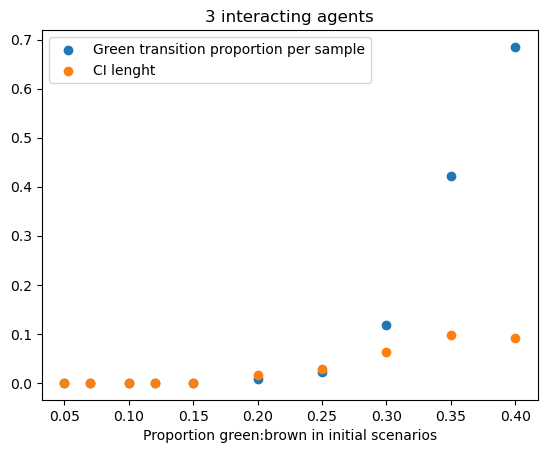

In [10]:
#Scatter plot
percentages
samples_proportion 
plt.scatter(percentages, samples_proportion, label= "Green transition proportion per sample")
plt.scatter(percentages, samples_CI_lenght, label="CI lenght")
plt.xlabel("Proportion green:brown in initial scenarios")
plt.title("3 interacting agents")
plt.legend()
plt.show()

In [11]:
#Microvariables
#Select microvariables we are interested
production = FARMS[['P_B', 'P_G']]
#shape data as  production vectors
productions = production.stack(level=-1)
#starting points from t=[0:periods-1]
xs = productions.loc[:,:,:,:periods-1]
xs_farms = xs.unstack(level=0).unstack(level=0).unstack(level=1)
xs_farms = xs_farms.to_numpy()

#propagation points from t= [1:periods]
ys = productions.loc[:,:,:,1:]
ys_farms = ys.unstack(level=0).unstack(level=0).unstack(level=1)
ys_farms = ys_farms.to_numpy()

In [12]:
#Macrovariables
macro_var = STATS[['G_farms', 'GOS']]
macro_var = macro_var.stack(level=-1)
#starting points from t=[0:periods-1]
xs_macro = macro_var.loc[:,:,:,:periods-1]
xs_macro = xs_macro.unstack(level=0).unstack(level=0).unstack(level=1)
xs_macro = xs_macro.to_numpy()

#Propagating points from t=[1:periods]
ys_macro = macro_var.loc[:,:,:,1:]
ys_macro = ys_macro.unstack(level=0).unstack(level=0).unstack(level=1)
ys_macro = ys_macro.to_numpy()

In [13]:
#construct data structures
#Construct starting points
xs = np.vstack((xs_farms, xs_macro))
#Construct propagating points
ys = np.vstack((ys_farms, ys_macro))

In [14]:
#Check if the shape of both are the same
xs.shape == ys.shape

True

In [15]:
#reshape ys to the required structure for ISOKANN
ndim, nsample = ys.shape[0], ys.shape[1]

ys = ys.reshape(ndim, 1, nsample) 

In [16]:
#save data to get them into Julia

# Create the path and ensure the directory exists for saving the data
data_dir = os.path.join( "..", 'data', 'simulations')
os.makedirs(data_dir, exist_ok=True)

# Build full path
file_path = os.path.join(data_dir, "2025-10-20-data_VD_FC_3InteractingAgents_rand_init_capital.npz")

# Save xs and ys in the same file
np.savez(file_path, xs=xs, ys=ys)